In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tmp import process_electricity_data
import pandas as pd

In [4]:
df = process_electricity_data('data/electricityloaddiagrams20112014/LD2011_2014.txt')

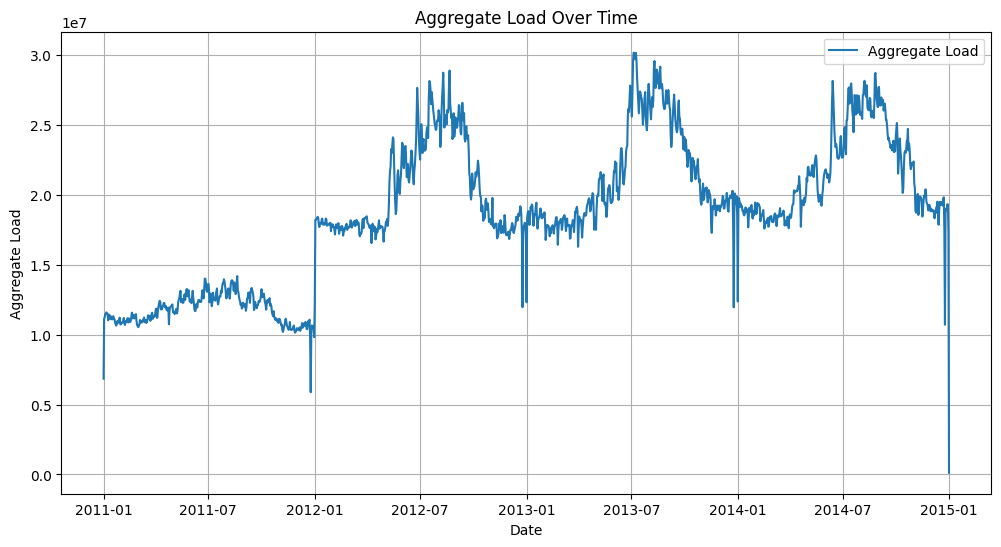

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["aggregate"], label="Aggregate Load")
plt.xlabel("Date")
plt.ylabel("Aggregate Load")
plt.title("Aggregate Load Over Time")
plt.legend()
plt.grid(True)
plt.show()

### Experimenting with priors

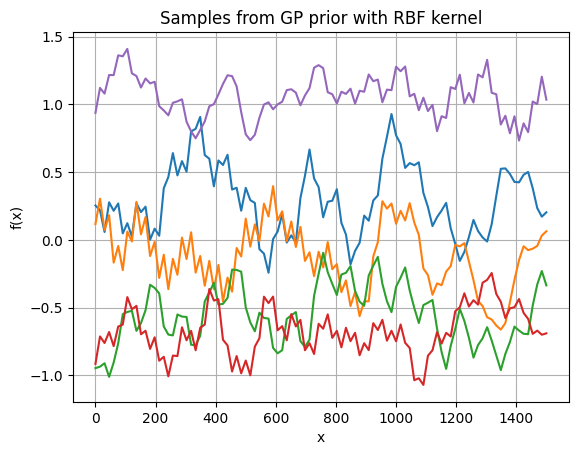

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from kernels import SumKernel, RBFKernel, PeriodicKernel
from numpy.random import default_rng

rng = default_rng()
X = np.linspace(0, 1500, 100).reshape(-1, 1)
rbf = RBFKernel(lengthscale=50., variance=0.05)
per1 = PeriodicKernel(period=365., lengthscale=50., variance=0.5)
per2 = PeriodicKernel(period=30.5,lengthscale=10., variance=0.2)
per3 = PeriodicKernel(period=7.,   lengthscale=5.,  variance=0.1)
kernel = SumKernel(rbf, per1, per2, per3)
K = kernel(X, X)

# Add a small nugget for numerical stability
K += 1e-8 * np.eye(len(X))
samples = rng.multivariate_normal(mean=np.zeros(len(X)), cov=K, size=5)

for i in range(samples.shape[0]):
    plt.plot(X, samples[i], lw=1.5)
plt.title("Samples from GP prior with RBF kernel")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

In [47]:
import os
import pandas as pd

def load_daily_aggregate(txt_path, data_dir='data', force_reload=False):
    # Define the path where the processed dataframe will be saved
    processed_path = os.path.join(data_dir, "daily_aggregate.pkl")
    
    # Check if the processed file exists and we're not forcing a reload
    if os.path.exists(processed_path) and not force_reload:
        print("Loading pre-processed data...")
        # Load the pre-processed data
        daily = pd.read_pickle(processed_path)
        return daily
    
    # If we need to process the data
    print("Processing raw data...")
    df = pd.read_csv(txt_path, sep=';', index_col=0, parse_dates=True, low_memory=False)
    df = df.replace(',', '.', regex=True).astype(float)
    df['total'] = df.sum(axis=1)
    daily = df[['total']].resample('D').sum()
    
    # Save the processed data
    print("Saving processed data for future use...")
    daily.to_pickle(processed_path)
    
    return daily

daily = load_daily_aggregate('data/electricityloaddiagrams20112014/LD2011_2014.txt')
daily = daily.loc['2012-01-01':'2014-12-31']
daily['t_day'] = (daily.index - daily.index[0]).days

# train/test split
train = daily.loc[:'2013-12-31']
test  = daily.loc['2014-01-01':]

X_train = train['t_day'].values.reshape(-1,1)
y_train = train['total'].values
X_test  = test ['t_day'].values.reshape(-1,1)
y_test  = test ['total'].values

ym, ys = y_train.mean(), y_train.std()
ytr_n = (y_train - ym)/ys
yte_n = (y_test  - ym)/ys

Loading pre-processed data...


### Hyperparameter optimization

In [48]:
import optuna
from sklearn.metrics import mean_squared_error
from model import OnlineSparseGP

def train_and_evaluate(params):
    # Unpack parameters
    rbf_len, rbf_var = params['rbf_len'], params['rbf_var']
    per1_len, per1_var = params['per1_len'], params['per1_var']
    per2_len, per2_var = params['per2_len'], params['per2_var']
    per3_len, per3_var = params['per3_len'], params['per3_var']
    noise_var = params['noise_var']

    # Define kernel
    rbf = RBFKernel(lengthscale=rbf_len, variance=rbf_var)
    per1 = PeriodicKernel(period=365., lengthscale=per1_len, variance=per1_var)
    per2 = PeriodicKernel(period=30.5, lengthscale=per2_len, variance=per2_var)
    per3 = PeriodicKernel(period=7., lengthscale=per3_len, variance=per3_var)
    Ksum = SumKernel(rbf, per1, per2, per3)

    # Initialize model
    Z0 = X_train[:20]
    gp = OnlineSparseGP(Ksum, noise_var=noise_var, max_points=125)
    gp.initialize(Z0, ytr_n[:20])

    # Streaming test phase
    preds_te = []
    for x, y in zip(X_test, yte_n):
        μ, σ2 = gp.predict(x)
        preds_te.append(μ[0])
        gp.add_point(x, y)

    # Denormalize predictions
    p_te = np.array(preds_te) * ys + ym
    a_te = y_test[:len(p_te)]
    return mean_squared_error(a_te, p_te)


def objective(trial):
    params = {
        'rbf_len': trial.suggest_loguniform('rbf_len', 1e-1, 20),
        'rbf_var': trial.suggest_loguniform('rbf_var', 1e-2, 10),
        'per1_len': trial.suggest_loguniform('per1_len', 5, 100),
        'per1_var': trial.suggest_loguniform('per1_var', 1e-2, 2),
        'per2_len': trial.suggest_loguniform('per2_len', 2, 50),
        'per2_var': trial.suggest_loguniform('per2_var', 1e-2, 2),
        'per3_len': trial.suggest_loguniform('per3_len', 1, 20),
        'per3_var': trial.suggest_loguniform('per3_var', 1e-2, 2),
        'noise_var': trial.suggest_loguniform('noise_var', 1e-4, 1),
    }
    return train_and_evaluate(params)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)


c:\Users\Arul\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-18 02:26:48,008] A new study created in memory with name: no-name-a463fba4-4299-47d9-ab7d-56e996ba41e8
C:\Users\Arul\AppData\Local\Temp\ipykernel_24368\733034173.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'rbf_len': trial.suggest_loguniform('rbf_len', 1e-1, 20),
C:\Users\Arul\AppData\Local\Temp\ipykernel_24368\733034173.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'rbf_var': 

Best hyperparameters: {'rbf_len': 4.948961837424606, 'rbf_var': 0.034725889070655436, 'per1_len': 72.3039510055688, 'per1_var': 1.1367173558614303, 'per2_len': 24.486552583062952, 'per2_var': 0.03460830317302234, 'per3_len': 2.9979970724403815, 'per3_var': 0.031133591413764025, 'noise_var': 0.002322246118810783}
